<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RandomForestRegressor

import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)

In [3]:
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Πωρνόσ στησ στράταν, τζ' ενωρίς στο κονατζιν (Κύπρος) -- predicted as: Cyprus


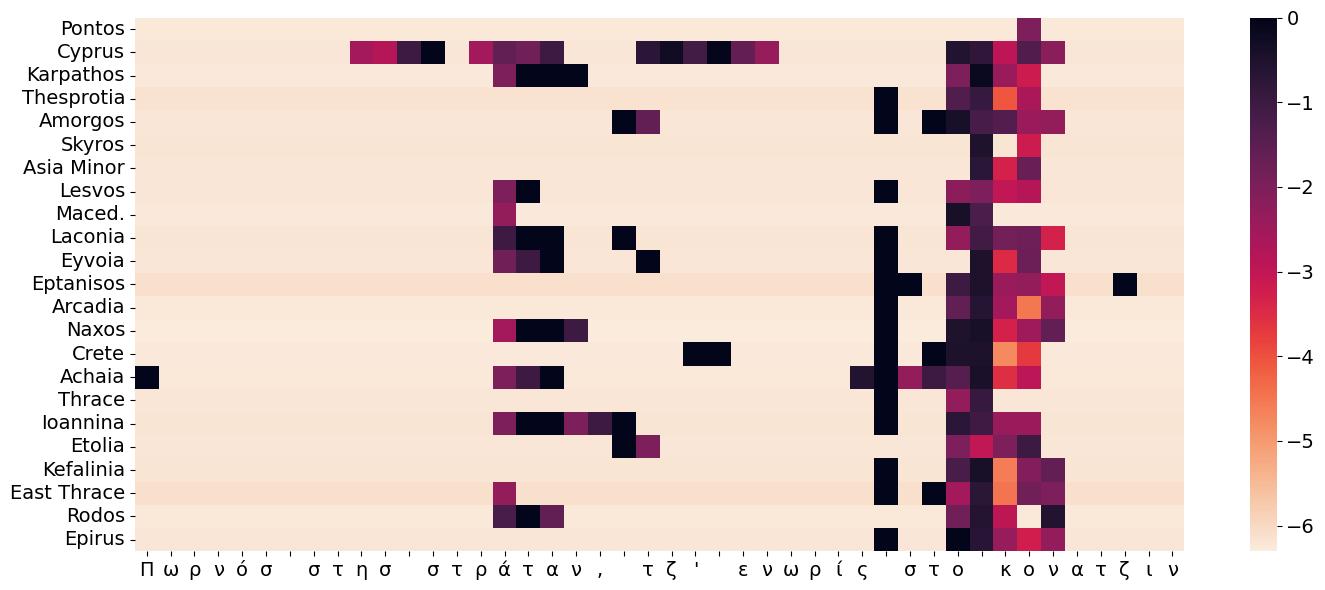

In [103]:
t = test[(test.area == "Κύπρος") & test.text.str.startswith('Πωρνό')].iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
plt.tick_params(axis='both', which='major', labelsize=14)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
ax.figure.tight_layout()
ax.figure.savefig("heatmap.pdf", format="PDF")

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

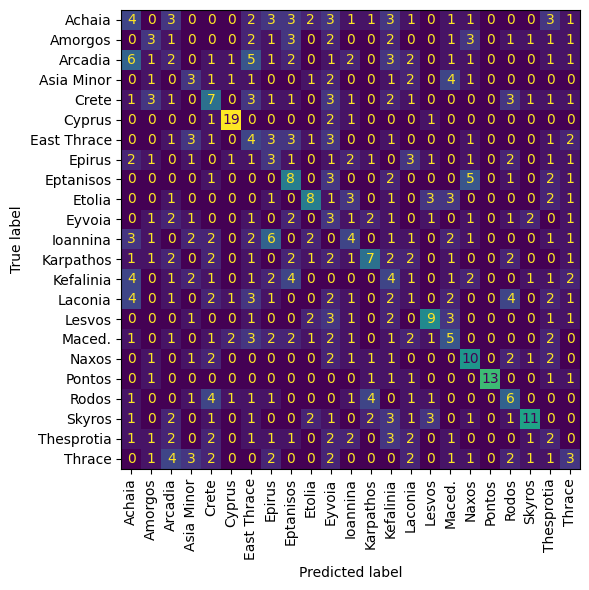

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

## Benchmarking standard text classifiers, on top of chanracter n-grams

In [15]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
print('Vocabulary:', len(vect.vocabulary_))
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

Vocabulary: 81402
n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


### Logistic Regression

In [13]:
vect = TfidfVectorizer(ngram_range=(2, 5), 
                       analyzer="char",
                       max_df=0.5, 
                       min_df=2, lowercase=True)

regressor = LogisticRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe,
                         train.text.values,
                         train.area.values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
print(cv_score)

pipe = Pipeline([('vect', vect), ('clf', LogisticRegression())])
pipe.fit(train.text, train.area)
preds = pipe.predict(test.text)
print(f'LogisticRegression\n{classification_report(test.area.values, preds)}')

0.28628019323671494
LogisticRegression
                 precision    recall  f1-score   support

        Ήπειρος       0.20      0.22      0.21        23
        Αιτωλία       0.36      0.58      0.44        24
        Αμοργός       0.13      0.18      0.15        22
Ανατολική Θράκη       0.16      0.21      0.18        24
        Αρκαδία       0.20      0.16      0.18        31
          Αχαΐα       0.39      0.22      0.28        32
      Επτάνησος       0.34      0.65      0.45        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.05      0.05      0.05        22
          Θράκη       0.25      0.16      0.20        25
       Ιωάννινα       0.30      0.21      0.24        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.14      0.11      0.12        27
          Κρήτη       0.35      0.27      0.30        30
         Κύπρος       0.72      0.75      0.73        24
         Λέσβος       0.41      0.58      0.48  

### SVM

In [28]:
def objective(trial):

    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])

    classifier = LinearSVC(C=C, penalty=penalty, dual=False, max_iter=5000)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-10 19:22:37,657] A new study created in memory with name: no-name-232e8730-ae0c-4bcd-95fc-acc0f330e500
[I 2023-06-10 19:22:40,417] Trial 1 finished with value: 0.04434782608695652 and parameters: {'C': 0.00913365036392995, 'penalty': 'l1', 'loss': 'squared_hinge'}. Best is trial 1 with value: 0.04434782608695652.
[I 2023-06-10 19:22:40,975] Trial 0 finished with value: 0.2674396135265701 and parameters: {'C': 0.011727997271561033, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 0 with value: 0.2674396135265701.
[I 2023-06-10 19:22:42,030] Trial 2 finished with value: 0.043188405797101447 and parameters: {'C': 3.6937644735477824e-06, 'penalty': 'l1', 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.2674396135265701.
[I 2023-06-10 19:22:46,453] Trial 4 finished with value: 0.28251207729468597 and parameters: {'C': 0.034497669104562034, 'penalty': 'l2', 'loss': 'squared_hinge'}. Best is trial 4 with value: 0.28251207729468597.
[I 2023-06-10 19:22:47,385] Trial 5 finishe

[I 2023-06-10 19:27:00,912] Trial 40 finished with value: 0.28289855072463765 and parameters: {'C': 595595.0082319903, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 6 with value: 0.292463768115942.
[I 2023-06-10 19:27:03,503] Trial 41 finished with value: 0.2835748792270531 and parameters: {'C': 805013.4149011874, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 6 with value: 0.292463768115942.
[I 2023-06-10 19:27:06,937] Trial 42 finished with value: 0.2997101449275362 and parameters: {'C': 0.18896483555452978, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 42 with value: 0.2997101449275362.
[I 2023-06-10 19:27:10,085] Trial 43 finished with value: 0.28309178743961355 and parameters: {'C': 59491.983977142925, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 42 with value: 0.2997101449275362.
[I 2023-06-10 19:27:13,740] Trial 44 finished with value: 0.28328502415458934 and parameters: {'C': 20912.779108814, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 42 with value: 0.29971014

[I 2023-06-10 19:28:45,241] Trial 80 finished with value: 0.29014492753623183 and parameters: {'C': 2.20103317861631, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 50 with value: 0.3008695652173913.
[I 2023-06-10 19:28:51,334] Trial 81 finished with value: 0.29584541062801933 and parameters: {'C': 1.1335027057788138, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 50 with value: 0.3008695652173913.
[I 2023-06-10 19:29:02,031] Trial 82 finished with value: 0.28077294685990334 and parameters: {'C': 17.280761017838174, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 50 with value: 0.3008695652173913.
[I 2023-06-10 19:29:05,528] Trial 83 finished with value: 0.2811594202898551 and parameters: {'C': 11.326218787046614, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 50 with value: 0.3008695652173913.
[I 2023-06-10 19:29:15,173] Trial 84 finished with value: 0.2816425120772947 and parameters: {'C': 9.630669621672324, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 50 with value: 0.300

In [29]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.3008695652173913
best trial: FrozenTrial(number=50, state=TrialState.COMPLETE, values=[0.3008695652173913], datetime_start=datetime.datetime(2023, 6, 10, 19, 27, 0, 915756), datetime_complete=datetime.datetime(2023, 6, 10, 19, 27, 30, 233312), params={'C': 0.31193366798166167, 'penalty': 'l2', 'loss': 'hinge'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'loss': CategoricalDistribution(choices=('hinge', 'squared_hinge'))}, trial_id=50, value=None)
best params: {'C': 0.31193366798166167, 'penalty': 'l2', 'loss': 'hinge'}


In [30]:
classifier = LinearSVC(**best_params,  dual=False, max_iter=5000)
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

### KNN

In [31]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors,
                                      weights=weights,
                                      p=p)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-10 19:31:42,395] A new study created in memory with name: no-name-850ec991-10c7-447f-8781-767c0a0f36e6
[I 2023-06-10 19:31:48,581] Trial 1 finished with value: 0.043188405797101447 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.043188405797101447.
[I 2023-06-10 19:34:01,588] Trial 5 finished with value: 0.21304347826086953 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.21304347826086953.
[I 2023-06-10 19:34:10,227] Trial 4 finished with value: 0.042705314009661835 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.21304347826086953.
[I 2023-06-10 19:36:21,239] Trial 2 finished with value: 0.1986473429951691 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'p': 2}. Best is trial 5 with value: 0.21304347826086953.
[I 2023-06-10 19:36:23,147] Trial 0 finished with value: 0.17207729468599034 and parameters: {'n_neighbors': 3

[I 2023-06-10 20:19:09,455] Trial 42 finished with value: 0.20415458937198067 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:19:12,686] Trial 43 finished with value: 0.21536231884057971 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:21:25,807] Trial 44 finished with value: 0.21536231884057971 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:21:29,204] Trial 45 finished with value: 0.21536231884057971 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:23:42,676] Trial 46 finished with value: 0.21536231884057971 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:23:

[I 2023-06-10 20:56:22,436] Trial 84 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:57:20,279] Trial 85 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:58:38,948] Trial 86 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 20:59:36,732] Trial 87 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 21:00:54,487] Trial 88 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 19 with value: 0.21594202898550724.
[I 2023-06-10 21:01:

In [32]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.21594202898550724
best trial: FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.21594202898550724], datetime_start=datetime.datetime(2023, 6, 10, 19, 38, 46, 731295), datetime_complete=datetime.datetime(2023, 6, 10, 19, 50, 5, 217270), params={'n_neighbors': 50, 'weights': 'distance', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=19, value=None)
best params: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}


In [33]:
classifier = KNeighborsClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.24347826086956523

In [34]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.05        23
        Αιτωλία       0.27      0.29      0.28        24
        Αμοργός       0.21      0.27      0.24        22
Ανατολική Θράκη       0.14      0.21      0.17        24
        Αρκαδία       0.08      0.06      0.07        31
          Αχαΐα       0.21      0.19      0.20        32
      Επτάνησος       0.28      0.57      0.37        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.09      0.09      0.09        22
          Θράκη       0.19      0.12      0.15        25
       Ιωάννινα       0.13      0.07      0.09        29
       Κάρπαθος       0.33      0.21      0.26        28
     Κεφαλληνία       0.16      0.19      0.17        27
          Κρήτη       0.26      0.20      0.23        30
         Κύπρος       0.52      0.71      0.60        24
         Λέσβος       0.37      0.46      0.41        24
        Λακωνία       0.11    

In [37]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    classifier = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-10 21:25:16,189] A new study created in memory with name: no-name-5cd8b78c-dee9-45cd-96ee-fdc162bd54db
[I 2023-06-10 21:25:21,301] Trial 0 finished with value: 0.2097584541062802 and parameters: {'n_estimators': 247, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2097584541062802.
[I 2023-06-10 21:25:24,117] Trial 4 finished with value: 0.21449275362318837 and parameters: {'n_estimators': 211, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.21449275362318837.
[I 2023-06-10 21:25:27,717] Trial 9 finished with value: 0.1978743961352657 and parameters: {'n_estimators': 148, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.21449275362318837.
[I 2023-06-10 21:25:27,828] Trial 1 finished with value: 0.20985507246376814 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 4 with val

[I 2023-06-10 21:26:47,921] Trial 37 finished with value: 0.2173913043478261 and parameters: {'n_estimators': 112, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.24202898550724639.
[I 2023-06-10 21:26:50,468] Trial 36 finished with value: 0.23342995169082123 and parameters: {'n_estimators': 373, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.24202898550724639.
[I 2023-06-10 21:26:54,115] Trial 38 finished with value: 0.23275362318840576 and parameters: {'n_estimators': 362, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.24202898550724639.
[I 2023-06-10 21:26:55,469] Trial 39 finished with value: 0.23236714975845413 and parameters: {'n_estimators': 370, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.24202898550724639.
[I 2023-06-10 21:26:57,925] Trial 40 finished with value: 0.23256038647342997

[I 2023-06-10 21:28:32,829] Trial 72 finished with value: 0.2336231884057971 and parameters: {'n_estimators': 283, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 63 with value: 0.247536231884058.
[I 2023-06-10 21:28:36,509] Trial 73 finished with value: 0.2314009661835749 and parameters: {'n_estimators': 293, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 63 with value: 0.247536231884058.
[I 2023-06-10 21:28:39,161] Trial 74 finished with value: 0.24405797101449273 and parameters: {'n_estimators': 337, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 63 with value: 0.247536231884058.
[I 2023-06-10 21:28:41,672] Trial 75 finished with value: 0.22908212560386473 and parameters: {'n_estimators': 336, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.247536231884058.
[I 2023-06-10 21:28:45,144] Trial 76 finished with value: 0.24299516908212562 and par

In [38]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.247536231884058
best trial: FrozenTrial(number=63, state=TrialState.COMPLETE, values=[0.247536231884058], datetime_start=datetime.datetime(2023, 6, 10, 21, 27, 35, 925656), datetime_complete=datetime.datetime(2023, 6, 10, 21, 28, 12, 937279), params={'n_estimators': 329, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=63, value=None)
best params: {'n_estimators': 329, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}


In [39]:
classifier = RandomForestClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.3060869565217391

In [40]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.33      0.13      0.19        23
        Αιτωλία       0.21      0.50      0.30        24
        Αμοργός       0.08      0.14      0.10        22
Ανατολική Θράκη       0.18      0.25      0.21        24
        Αρκαδία       0.11      0.13      0.12        31
          Αχαΐα       0.64      0.28      0.39        32
      Επτάνησος       0.30      0.39      0.34        23
         Εύβοια       0.00      0.00      0.00        20
      Θεσπρωτία       0.08      0.09      0.09        22
          Θράκη       0.23      0.12      0.16        25
       Ιωάννινα       0.10      0.07      0.08        29
       Κάρπαθος       0.57      0.29      0.38        28
     Κεφαλληνία       0.26      0.19      0.22        27
          Κρήτη       0.38      0.17      0.23        30
         Κύπρος       0.50      0.79      0.61        24
         Λέσβος       0.30      0.46      0.36        24
        Λακωνία       0.09    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [41]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
1,"Άβολος ο νους, διπλός ο κόπος","{Νίσυρος, Μικρά Ασία>Τσεσμές (Κρήνη)}",2,"{Μικρά Ασία, Νίσυρος}",2,"[(36.58904575, 27.16918402255752), (38.1846366..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θράκη, Θήρα (Σαντορίνη)}",2,"[(40.8464241, 25.8759377), (36.4044251, 25.395..."
3,"Άβουλος νους, διπλός ο κόπος","{Κρήτη, Ρόδος, Αμοργός}",3,"{Κρήτη, Ρόδος, Αμοργός}",3,"[(36.85252415, 25.89848696771565), (35.3084952..."
4,Άβουλος ο νους διπλός ο κόπος,"{Ήπειρος>Τσαμαντάς, Θράκη>Μάδυτος, Θράκη, Ρόδο...",5,"{Θράκη, Ήπειρος, Ρόδος, Σάμος}",4,"[(40.8464241, 25.8759377), (37.9574332, 23.710..."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Αργολίδα, Λέρος}",2,"[(37.56626615, 22.85593894780862), (37.1494507..."
3200,πονάει το δόντι,"{Θεσσαλία>Τρίκαλα, Φωκίδα}",2,"{Θεσσαλία, Φωκίδα}",2,"[(38.4998681, 22.24878032919352), (39.5594194,..."
3201,"που Πάτρα, που Φλομίτσι!","{Μάνη>Αβία, Μεσσηνία>Αβία>Κάμπος}",2,"{Μεσσηνία, Μάνη}",2,"[(36.986899050000005, 21.82712495001949), (41...."
3202,τού έδειξε τα δόντια,"{Αρκαδία>Τεγέα, Εύβοια}",2,"{Εύβοια, Αρκαδία}",2,"[(38.0368583, 23.6689264), (38.49417235, 23.91..."


In [42]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
6,Άγιασε ο μαχαιροβγάλτης και πουλεί σκουρολεπίδες,"{Ήπειρος, Κεφαλληνία}",2,"{Ήπειρος, Κεφαλληνία}",Κεφαλληνία,2,"[(37.9574332, 23.7108518), (38.2379344, 20.560..."
2171,Ο Μανώλης με τα λόγια κτίζ' ανώγεια και κατώγεια,"{Κρήτη>Σητεία>Χαμέζι, Ιωάννινα}",2,"{Κρήτη, Ιωάννινα}",Κρήτη,2,"[(35.3084952, 24.46334231842296), (39.6639818,..."
2163,Ο Θεός να σε φυλάη από σπανό άντρα και μουστακ...,"{Μάνη, Κρήτη>Σητεία>Χαμέζι}",2,"{Μάνη, Κρήτη}",Κρήτη,2,"[(41.4097472, 26.4024952), (35.3084952, 24.463..."
2159,Ο Θεός κάνει σκάλες κι άλλους ανεβάζει κι άλλο...,"{Αρκαδία>Γορτυνία, Λακωνία}",2,"{Αρκαδία, Λακωνία}",Αρκαδία,2,"[(38.0368583, 23.6689264), (36.76027945, 22.79..."
2139,Ξύλω τον Αδάμ κατάρας ελυτρώσω,"{Πόντος, Θράκη>Μάδυτος}",2,"{Πόντος, Θράκη}",Πόντος,2,"[(40.8464241, 25.8759377), (40.0850088, 23.977..."


* Showing the ones our classifier located on Cyrpus.

In [43]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
137,"Άρον, άρον","{Ήπειρος, Κύπρος}",2,"{Ήπειρος, Κύπρος}",Κύπρος,2,"[(34.9823018, 33.1451285), (37.9574332, 23.710..."
525,"Όπου δεμ πέφτει λόγος, πέφτει ράβδος","{Κύπρος, Νίσυρος}",2,"{Κύπρος, Νίσυρος}",Κύπρος,2,"[(36.58904575, 27.16918402255752), (34.9823018..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [61]:
optimization_results = []

In [62]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                       min_df=10, lowercase=True)

regressor = LinearRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe, 
                         train.text.values, 
                         train[["lat", "lon"]].values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
cv_score

0.12157069318821215

In [63]:
linear_regression_pipe = Pipeline([('vect', vect), ('reg', regressor)])
linear_regression_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = linear_regression_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.19721894514520716

In [64]:
predicted_coords = linear_regression_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'LinearRegression', 
    cv_score, 
    score,
    None,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3052700069768668 1.8227471474972385
2.704765390894777 5.5683377877965885


In [65]:
def objective(trial):

    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-10 21:59:51,625] A new study created in memory with name: no-name-e4e5defe-d9d0-49a9-a6a1-6cbc244bf00b
[I 2023-06-10 21:59:52,032] Trial 0 finished with value: 0.1438418629521843 and parameters: {'alpha': 0.0002383200608512922, 'l1_ratio': 0.2760838797301802}. Best is trial 0 with value: 0.1438418629521843.
[I 2023-06-10 21:59:52,447] Trial 1 finished with value: 0.1400040001266411 and parameters: {'alpha': 0.00017085154770748795, 'l1_ratio': 0.06568162479657547}. Best is trial 0 with value: 0.1438418629521843.
[I 2023-06-10 21:59:52,765] Trial 2 finished with value: 0.0021085085207002475 and parameters: {'alpha': 0.18397315846588622, 'l1_ratio': 0.04789525869457223}. Best is trial 0 with value: 0.1438418629521843.
[I 2023-06-10 21:59:53,057] Trial 3 finished with value: -0.0004066991582208246 and parameters: {'alpha': 0.7783028800585803, 'l1_ratio': 0.9789869904337763}. Best is trial 0 with value: 0.1438418629521843.
[I 2023-06-10 21:59:53,140] Trial 4 finished with value: 

[I 2023-06-10 21:59:58,327] Trial 39 finished with value: 0.14843054322694632 and parameters: {'alpha': 0.00035912996546862196, 'l1_ratio': 0.7342179561609881}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 21:59:58,450] Trial 40 finished with value: 0.1289965511452919 and parameters: {'alpha': 0.0019595312199181293, 'l1_ratio': 0.5806562749172941}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 21:59:58,601] Trial 41 finished with value: 0.15122789289493643 and parameters: {'alpha': 0.0005182248871947585, 'l1_ratio': 0.6764465899433492}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 21:59:58,748] Trial 42 finished with value: 0.15140026295444725 and parameters: {'alpha': 0.0006804051988047884, 'l1_ratio': 0.6420047407865013}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 21:59:58,896] Trial 43 finished with value: 0.15150346780113344 and parameters: {'alpha': 0.0005970101654602492, 'l1_ratio': 0.6264047273984965}. Best

[I 2023-06-10 22:00:04,356] Trial 79 finished with value: 0.15022901238459535 and parameters: {'alpha': 0.0008348546475179038, 'l1_ratio': 0.7769399981864081}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 22:00:04,484] Trial 80 finished with value: 0.13364199056925993 and parameters: {'alpha': 0.0017303767626973968, 'l1_ratio': 0.66496720488599}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 22:00:04,632] Trial 81 finished with value: 0.15155618970257576 and parameters: {'alpha': 0.0006292171965389844, 'l1_ratio': 0.648636624623975}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 22:00:04,790] Trial 82 finished with value: 0.15014914141677613 and parameters: {'alpha': 0.0004330159658944427, 'l1_ratio': 0.6978717363524969}. Best is trial 23 with value: 0.1516539858659698.
[I 2023-06-10 22:00:04,935] Trial 83 finished with value: 0.15120507746237202 and parameters: {'alpha': 0.0007341031374735464, 'l1_ratio': 0.7496289899036064}. Best is

In [66]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.15168131594552212
best trial: FrozenTrial(number=93, state=TrialState.COMPLETE, values=[0.15168131594552212], datetime_start=datetime.datetime(2023, 6, 10, 22, 0, 6, 291267), datetime_complete=datetime.datetime(2023, 6, 10, 22, 0, 6, 440250), params={'alpha': 0.0006167913176584872, 'l1_ratio': 0.7277034948352414}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=93, value=None)
best params: {'alpha': 0.0006167913176584872, 'l1_ratio': 0.7277034948352414}


In [67]:
regressor = ElasticNet(**best_params)
elastic_net_pipe = Pipeline([('vect', vect), ('reg', regressor)])
elastic_net_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = elastic_net_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.2131466421753188

In [68]:
predicted_coords = elastic_net_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'ElasticNet', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.292756526910211 1.803654490312877
2.6274680630145903 5.516732661698541


In [69]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                    weights=weights, 
                                    p=p)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-10 22:00:07,588] A new study created in memory with name: no-name-e78deba2-3fc3-4143-ae35-41082856a26e
[I 2023-06-10 22:00:07,920] Trial 0 finished with value: 0.06038019224339136 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.06038019224339136.
[I 2023-06-10 22:00:08,501] Trial 1 finished with value: -0.20346178762846204 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.06038019224339136.
[I 2023-06-10 22:00:08,822] Trial 2 finished with value: 0.009304615004941508 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.06038019224339136.
[I 2023-06-10 22:00:09,394] Trial 3 finished with value: 0.005741604711188142 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.06038019224339136.
[I 2023-06-10 22:00:09,706] Trial 4 finished with value: 0.022335072639989417 and parameters: {'n_neighbors': 

[I 2023-06-10 22:00:23,105] Trial 42 finished with value: 0.058304460712380435 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:23,407] Trial 43 finished with value: 0.05508244157673888 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:23,713] Trial 44 finished with value: 0.05705639310227208 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:24,017] Trial 45 finished with value: 0.05910110302284377 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:24,584] Trial 46 finished with value: 0.006619417348061485 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'p': 1}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:24,

[I 2023-06-10 22:00:36,657] Trial 84 finished with value: 0.06208857752172975 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:36,963] Trial 85 finished with value: 0.05900260557532603 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:37,263] Trial 86 finished with value: 0.04176962138330444 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:37,565] Trial 87 finished with value: 0.05636961507449663 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:37,871] Trial 88 finished with value: 0.015198904595870522 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 2}. Best is trial 33 with value: 0.06208857752172975.
[I 2023-06-10 22:00:38,

In [70]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.06208857752172975
best trial: FrozenTrial(number=33, state=TrialState.COMPLETE, values=[0.06208857752172975], datetime_start=datetime.datetime(2023, 6, 10, 22, 0, 19, 551932), datetime_complete=datetime.datetime(2023, 6, 10, 22, 0, 19, 852840), params={'n_neighbors': 22, 'weights': 'uniform', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=33, value=None)
best params: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}


In [71]:
regressor = KNeighborsRegressor(**best_params)
knr_pipe = Pipeline([('vect', vect), ('reg', regressor)])
knr_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = knr_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.09255588232781126

In [72]:
predicted_coords = knr_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'KNeighborsRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3767530653913036 1.9567627980173916
2.9645297787499216 6.525672340286382


In [73]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-10 22:00:41,837] A new study created in memory with name: no-name-fff2bd52-fdaf-41ea-95b1-b9ef7d2644d3
[I 2023-06-10 22:00:44,422] Trial 0 finished with value: 0.1314512724856554 and parameters: {'n_estimators': 143, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.1314512724856554.
[I 2023-06-10 22:00:46,161] Trial 1 finished with value: 0.1317177464956311 and parameters: {'n_estimators': 115, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.1317177464956311.
[I 2023-06-10 22:00:46,709] Trial 2 finished with value: 0.10755228335377662 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.1317177464956311.
[I 2023-06-10 22:00:51,284] Trial 3 finished with value: 0.13044408319739054 and parameters: {'n_estimators': 323, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with val

[I 2023-06-10 22:04:11,396] Trial 36 finished with value: 0.1337846549813661 and parameters: {'n_estimators': 368, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 33 with value: 0.13574073925781374.
[I 2023-06-10 22:04:16,221] Trial 37 finished with value: 0.13093726433815878 and parameters: {'n_estimators': 335, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.13574073925781374.
[I 2023-06-10 22:04:19,126] Trial 38 finished with value: 0.12155227645657382 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 33 with value: 0.13574073925781374.
[I 2023-06-10 22:04:27,184] Trial 39 finished with value: 0.1319496325831272 and parameters: {'n_estimators': 383, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.13574073925781374.
[I 2023-06-10 22:04:37,023] Trial 40 finished with value: 0.13058857385688985 a

[I 2023-06-10 22:09:00,778] Trial 72 finished with value: 0.13653900286762524 and parameters: {'n_estimators': 401, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.13653900286762524.
[I 2023-06-10 22:09:08,957] Trial 73 finished with value: 0.13579070554243522 and parameters: {'n_estimators': 401, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 72 with value: 0.13653900286762524.
[I 2023-06-10 22:09:16,214] Trial 74 finished with value: 0.13409559691510417 and parameters: {'n_estimators': 367, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 72 with value: 0.13653900286762524.
[I 2023-06-10 22:09:23,219] Trial 75 finished with value: 0.13528437081027894 and parameters: {'n_estimators': 342, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 72 with value: 0.13653900286762524.
[I 2023-06-10 22:09:30,980] Trial 76 finished with value: 0.1346130513935730

In [74]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.13653900286762524
best trial: FrozenTrial(number=72, state=TrialState.COMPLETE, values=[0.13653900286762524], datetime_start=datetime.datetime(2023, 6, 10, 22, 8, 52, 380277), datetime_complete=datetime.datetime(2023, 6, 10, 22, 9, 0, 778527), params={'n_estimators': 401, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=72, value=None)
best params: {'n_estimators': 401, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 6}


In [75]:
regressor = RandomForestRegressor(**best_params)
random_forest_pipe = Pipeline([('vect', vect), ('reg', regressor)])
random_forest_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = random_forest_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.1805707960478662

In [76]:
predicted_coords = random_forest_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'RandomForestRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3085710703221725 1.819149206643716
2.7368178173562008 5.74370079356207


In [77]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-10 22:12:46,059] A new study created in memory with name: no-name-15323155-ad27-43c9-9d84-4f9e24aa902c
[I 2023-06-10 22:12:48,247] Trial 0 finished with value: 0.12545105235842913 and parameters: {'n_estimators': 425, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.12545105235842913.
[I 2023-06-10 22:12:50,336] Trial 1 finished with value: 0.12499617557088834 and parameters: {'n_estimators': 352, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.12545105235842913.
[I 2023-06-10 22:12:52,230] Trial 2 finished with value: 0.1281918897841264 and parameters: {'n_estimators': 376, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.1281918897841264.
[I 2023-06-10 22:12:55,655] Trial 3 finished with value: 0.1350051464312748 and parameters: {'n_estimators': 323, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 3 with 

[I 2023-06-10 22:13:49,192] Trial 36 finished with value: 0.12413577341600882 and parameters: {'n_estimators': 348, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.13569019094550236.
[I 2023-06-10 22:13:53,186] Trial 37 finished with value: 0.13498031653379589 and parameters: {'n_estimators': 389, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.13569019094550236.
[I 2023-06-10 22:13:56,729] Trial 38 finished with value: 0.13487459615148384 and parameters: {'n_estimators': 321, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.13569019094550236.
[I 2023-06-10 22:14:01,401] Trial 39 finished with value: 0.13547192273246203 and parameters: {'n_estimators': 413, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.13569019094550236.
[I 2023-06-10 22:14:05,948] Trial 40 finished with value: 0.135215308179717

[I 2023-06-10 22:16:22,054] Trial 72 finished with value: 0.13562504804746472 and parameters: {'n_estimators': 341, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 55 with value: 0.13591936481208586.
[I 2023-06-10 22:16:25,389] Trial 73 finished with value: 0.1357013970417768 and parameters: {'n_estimators': 279, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 55 with value: 0.13591936481208586.
[I 2023-06-10 22:16:28,752] Trial 74 finished with value: 0.13588612916400572 and parameters: {'n_estimators': 283, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 55 with value: 0.13591936481208586.
[I 2023-06-10 22:16:31,710] Trial 75 finished with value: 0.13598711369457192 and parameters: {'n_estimators': 243, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 75 with value: 0.13598711369457192.
[I 2023-06-10 22:16:34,731] Trial 76 finished with value: 0.13539237910772592

In [78]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.1361460389661183
best trial: FrozenTrial(number=91, state=TrialState.COMPLETE, values=[0.1361460389661183], datetime_start=datetime.datetime(2023, 6, 10, 22, 17, 18, 553074), datetime_complete=datetime.datetime(2023, 6, 10, 22, 17, 22, 142700), params={'n_estimators': 300, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=91, value=None)
best params: {'n_estimators': 300, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 8}


In [79]:
regressor = ExtraTreesRegressor(**best_params)
extra_trees_pipe = Pipeline([('vect', vect), ('reg', regressor)])
extra_trees_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = extra_trees_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.1761086258368953

In [80]:
predicted_coords = extra_trees_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'ExtraTreesRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.313757871369199 1.8251242328989503
2.7513312697394063 5.775948919859913


In [81]:
columns = [
    'regressor',
    'cv_score',
    'test_score',
    'best_params',
    'mae_lat', 
    'mae_lon',
    'mse_lat',
    'mse_lon'
]

optimization_results_df = pd.DataFrame(optimization_results, columns=columns)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon
0,LinearRegression,0.121571,0.197219,None,1.305270,1.822747,2.704765,5.568338
1,ElasticNet,0.151681,0.213147,"{'alpha': 0.0006167913176584872, 'l1_ratio': 0...",1.292757,1.803654,2.627468,5.516733
2,KNeighborsRegressor,0.062089,0.092556,"{'n_neighbors': 22, 'weights': 'uniform', 'p': 2}",1.376753,1.956763,2.964530,6.525672
3,RandomForestRegressor,0.136539,0.180571,"{'n_estimators': 401, 'max_depth': 32, 'min_sa...",1.308571,1.819149,2.736818,5.743701
4,ExtraTreesRegressor,0.136146,0.176109,"{'n_estimators': 300, 'max_depth': 32, 'min_sa...",1.313758,1.825124,2.751331,5.775949


* Having arrived at this point, it is worth pointing out that the $\alpha$ parameter of `ElasticNet` is very small:

In [86]:
optimization_results_df[optimization_results_df.regressor == 'ElasticNet']['best_params']

1    {'alpha': 0.0006167913176584872, 'l1_ratio': 0...
Name: best_params, dtype: object

* That means that in practice `ElasticNet` behaves pretty much like Ordinary Least Squares regression.

## Finding terms pushing North, South, West, and East

In [87]:
importance_pd = pd.DataFrame({"feature": elastic_net_pipe["vect"].get_feature_names_out(), 
                              "lat": elastic_net_pipe["reg"].coef_[0, :],
                              "lon": elastic_net_pipe["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [88]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,2.069563,0.000000
552,πε,1.744839,0.852717
96,ατ,1.657772,-0.407796
40,έφαγε,1.567535,0.061738
630,σο,1.470295,-0.322957


### Words pushing $\downarrow$ South: lower lat

In [89]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.143706,11.016613
662,τζαι,-3.665075,9.902281
661,τζαί,-3.540612,9.914528
664,τζι,-2.977478,8.586900
308,καλλιά,-1.995875,-0.000000


### Words pushing $\rightarrow$ East: higher lon

In [90]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
660,τζ,-4.143706,11.016613
661,τζαί,-3.540612,9.914528
662,τζαι,-3.665075,9.902281
664,τζι,-2.977478,8.586900
233,εμ,-1.799892,5.644582


### Words pushing $\leftarrow$ West: higher lon

In [91]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
466,ναν,0.000000,-2.758580
702,τσου,0.000000,-2.579741
107,αφέντη,0.000000,-2.157786
458,μύλο,0.000000,-1.798303
269,κάλλιο,0.375506,-1.793693
